# Ungraded Lab: Using a multi-layer LSTM for forecasting

In this lab, you will use the same RNN architecure in the first lab but will instead stack [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layers instead of `SimpleRNN`.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

2025-01-08 15:58:49.046784: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 15:58:49.055766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736326729.066111 1062701 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736326729.069310 1062701 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 15:58:49.080064: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Generate the Synthetic Data

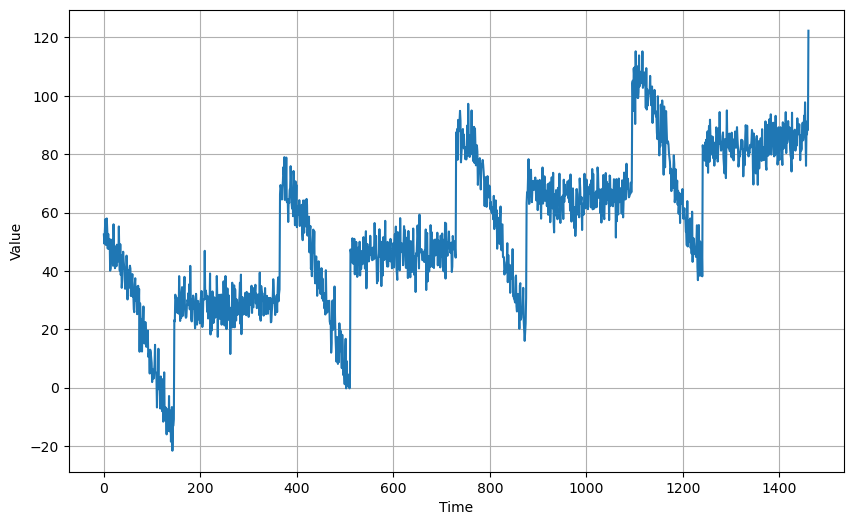

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

I0000 00:00:1736327067.206621 1062701 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10382 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1736327067.206996 1062701 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10393 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:05:00.0, compute capability: 8.6


## Build the Model

As mentioned, you will swap `SimpleRNN` for `LSTM` in this lab. It is also set as bidirectional below but feel free to revise later and see what results you get. LSTMs are much more complex in their internal architecture than simpleRNNs. It implements a cell state that allows it to remember sequences better than simple implementations. This added complexity results in a bigger set of parameters to train and you'll see that when you print the model summary below.

In [8]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 20, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

As usual, you will pick a learning rate by running the tuning code below.

In [9]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


I0000 00:00:1736327087.871240 1073971 cuda_dnn.cc:529] Loaded cuDNN version 90300


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 82.0550 - learning_rate: 1.0000e-08
Epoch 2/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 81.1202

2025-01-08 16:04:48.591409: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-08 16:04:48.591508: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2025-01-08 16:04:48.591582: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2137556908714512836
2025-01-08 16:04:48.591614: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2130697991027071916
/opt/miniconda3/envs/mylab-nilm-env/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  s

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 81.1722 - learning_rate: 1.1220e-08
Epoch 3/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 80.0043

2025-01-08 16:04:48.910574: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 80.0002 - learning_rate: 1.2589e-08
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 78.6959 - learning_rate: 1.4125e-08
Epoch 5/100
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 77.3011

2025-01-08 16:04:49.524902: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 77.2368 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 75.6103 - learning_rate: 1.7783e-08
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 73.7699 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 71.7199 - learning_rate: 2.2387e-08
Epoch 9/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 69.5816

2025-01-08 16:04:50.734601: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 69.4289 - learning_rate: 2.5119e-08
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 66.8740 - learning_rate: 2.8184e-08
Epoch 11/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 64.2476 

2025-01-08 16:04:51.331578: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2137556908714512836
2025-01-08 16:04:51.331654: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2130697991027071916
2025-01-08 16:04:51.331674: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16343883462942757621
2025-01-08 16:04:51.331685: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17297812422947320681


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 64.0229 - learning_rate: 3.1623e-08
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 60.8602 - learning_rate: 3.5481e-08
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 57.3369 - learning_rate: 3.9811e-08
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 53.4631 - learning_rate: 4.4668e-08
Epoch 15/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 49.6092

2025-01-08 16:04:52.553984: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2137556908714512836


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 49.1888 - learning_rate: 5.0119e-08
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 44.4978 - learning_rate: 5.6234e-08
Epoch 17/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 39.9226

2025-01-08 16:04:53.131924: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 39.3639 - learning_rate: 6.3096e-08
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 33.7797 - learning_rate: 7.0795e-08
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 27.7543 - learning_rate: 7.9433e-08
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 21.4188 - learning_rate: 8.9125e-08
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.5217 - learning_rate: 1.0000e-07
Epoch 22/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.3308 

2025-01-08 16:04:54.624591: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2137556908714512836
2025-01-08 16:04:54.624631: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2130697991027071916
2025-01-08 16:04:54.624638: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16907445931504510835
2025-01-08 16:04:54.624648: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16343883462942757621
2025-01-08 16:04:54.624654: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17297812422947320681
2025-01-08 16:04:54.624660: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 8352562487431081417


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 12.1915 - learning_rate: 1.1220e-07
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.0519 - learning_rate: 1.2589e-07
Epoch 24/100
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.6330

2025-01-08 16:04:55.144030: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2137556908714512836
2025-01-08 16:04:55.144059: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2130697991027071916
2025-01-08 16:04:55.144066: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16343883462942757621
2025-01-08 16:04:55.144069: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17297812422947320681


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.5908 - learning_rate: 1.4125e-07
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.3445 - learning_rate: 1.5849e-07
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.1673 - learning_rate: 1.7783e-07
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.0066 - learning_rate: 1.9953e-07
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.8470 - learning_rate: 2.2387e-07
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.6843 - learning_rate: 2.5119e-07
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.5133 - learning_rate: 2.8184e-07
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.3331 - learning_rate: 3.1623e-07
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1463 - learning_rate: 3.5481e-07
Epoch 33/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.9818

2025-01-08 16:04:57.527469: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.9557 - learning_rate: 3.9811e-07
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.7598 - learning_rate: 4.4668e-07
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.5520 - learning_rate: 5.0119e-07
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3271 - learning_rate: 5.6234e-07
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.0733 - learning_rate: 6.3096e-07
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.7734 - learning_rate: 7.0795e-07
Epoch 39/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.4224

2025-01-08 16:04:59.249735: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2137556908714512836
2025-01-08 16:04:59.249831: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2130697991027071916
2025-01-08 16:04:59.249848: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16907445931504510835
2025-01-08 16:04:59.249870: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16343883462942757621
2025-01-08 16:04:59.249885: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17297812422947320681
2025-01-08 16:04:59.249896: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 8352562487431081417


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.3846 - learning_rate: 7.9433e-07
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.0099 - learning_rate: 8.9125e-07
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.7643 - learning_rate: 1.0000e-06
Epoch 42/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5128

2025-01-08 16:05:00.045675: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2137556908714512836
2025-01-08 16:05:00.045743: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2130697991027071916
2025-01-08 16:05:00.045787: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16343883462942757621
2025-01-08 16:05:00.045801: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17297812422947320681


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5509 - learning_rate: 1.1220e-06
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.3651 - learning_rate: 1.2589e-06
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.1978 - learning_rate: 1.4125e-06
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0435 - learning_rate: 1.5849e-06
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9377 - learning_rate: 1.7783e-06
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8119 - learning_rate: 1.9953e-06
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7158 - learning_rate: 2.2387e-06
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.5735 - learning_rate: 2.5119e-06
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4666 - learning_rate: 2.8184e-06
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3237 - learning_rate: 3.1623e-06
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 

2025-01-08 16:05:05.820324: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5761 - learning_rate: 1.5849e-05
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2221 - learning_rate: 1.7783e-05
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4602 - learning_rate: 1.9953e-05
Epoch 68/100
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2714

2025-01-08 16:05:06.639968: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2137556908714512836
2025-01-08 16:05:06.639988: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2130697991027071916
2025-01-08 16:05:06.639992: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16907445931504510835
2025-01-08 16:05:06.639997: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16343883462942757621
2025-01-08 16:05:06.640000: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17297812422947320681
2025-01-08 16:05:06.640002: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 8352562487431081417


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4487 - learning_rate: 2.2387e-05
Epoch 69/100
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8740

2025-01-08 16:05:06.913201: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2137556908714512836
2025-01-08 16:05:06.913255: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2130697991027071916
2025-01-08 16:05:06.913274: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16343883462942757621
2025-01-08 16:05:06.913285: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17297812422947320681


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0017 - learning_rate: 2.5119e-05
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6285 - learning_rate: 2.8184e-05
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5086 - learning_rate: 3.1623e-05
Epoch 72/100
 2/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6865

2025-01-08 16:05:07.500683: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2137556908714512836
2025-01-08 16:05:07.500728: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2130697991027071916
2025-01-08 16:05:07.500743: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16343883462942757621
2025-01-08 16:05:07.500752: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17297812422947320681


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3636 - learning_rate: 3.5481e-05
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3324 - learning_rate: 3.9811e-05
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.9221 - learning_rate: 4.4668e-05
Epoch 75/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4670

2025-01-08 16:05:08.659900: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2137556908714512836


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.8313 - learning_rate: 5.0119e-05
Epoch 76/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.0509 - learning_rate: 5.6234e-05
Epoch 77/100
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8829

2025-01-08 16:05:09.199903: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2137556908714512836
2025-01-08 16:05:09.199976: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2130697991027071916
2025-01-08 16:05:09.200011: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16343883462942757621
2025-01-08 16:05:09.200031: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17297812422947320681


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8413 - learning_rate: 6.3096e-05
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1290 - learning_rate: 7.0795e-05
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.0151 - learning_rate: 7.9433e-05
Epoch 80/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.2152

2025-01-08 16:05:09.945291: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2137556908714512836
2025-01-08 16:05:09.945349: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2130697991027071916
2025-01-08 16:05:09.945361: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16907445931504510835
2025-01-08 16:05:09.945377: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16343883462942757621
2025-01-08 16:05:09.945389: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17297812422947320681
2025-01-08 16:05:09.945398: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 8352562487431081417


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.3991 - learning_rate: 8.9125e-05
Epoch 81/100
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2936

2025-01-08 16:05:10.228529: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2137556908714512836
2025-01-08 16:05:10.228552: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2130697991027071916
2025-01-08 16:05:10.228557: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16343883462942757621
2025-01-08 16:05:10.228560: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17297812422947320681


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2087 - learning_rate: 1.0000e-04
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5634 - learning_rate: 1.1220e-04
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.5531 - learning_rate: 1.2589e-04
Epoch 84/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2355

2025-01-08 16:05:11.045324: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2137556908714512836


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6311 - learning_rate: 1.4125e-04
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0402 - learning_rate: 1.5849e-04
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.7624 - learning_rate: 1.7783e-04
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.8709 - learning_rate: 1.9953e-04
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.2098 - learning_rate: 2.2387e-04
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.3328 - learning_rate: 2.5119e-04
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.4207 - learning_rate: 2.8184e-04
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.6512 - learning_rate: 3.1623e-04
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.2656 - learning_rate: 3.5481e-04
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.3263 - learning_rate: 3.9811e-04
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss

2025-01-08 16:05:14.359508: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2137556908714512836
2025-01-08 16:05:14.359551: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2130697991027071916
2025-01-08 16:05:14.359559: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16907445931504510835
2025-01-08 16:05:14.359569: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16343883462942757621
2025-01-08 16:05:14.359577: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17297812422947320681
2025-01-08 16:05:14.359582: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 8352562487431081417


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.8042 - learning_rate: 5.6234e-04
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.8055 - learning_rate: 6.3096e-04
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1449 - learning_rate: 7.0795e-04
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.8300 - learning_rate: 7.9433e-04
Epoch 100/100
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.9083

2025-01-08 16:05:15.318406: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2137556908714512836
2025-01-08 16:05:15.318465: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2130697991027071916
2025-01-08 16:05:15.318487: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16343883462942757621
2025-01-08 16:05:15.318498: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17297812422947320681


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.8437 - learning_rate: 8.9125e-04


(1e-08, 0.001, 0.0, 30.0)

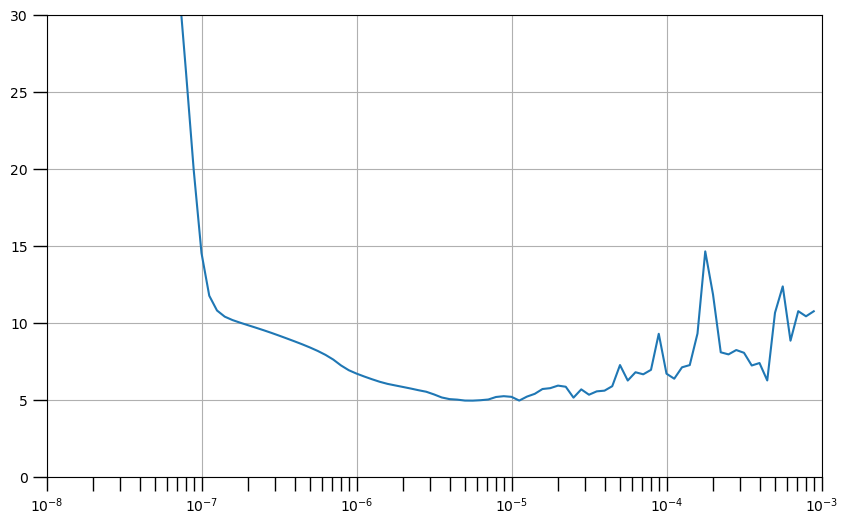

In [10]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

## Train the Model

You can then proceed to train the model with your chosen learning rate. 

*Tip: When experimenting and you find yourself running different iterations of a model, you may want to use the [`clear_session()`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session) method to declutter memory used by Keras. This is added in the first line below.*


In [11]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 22.0557 - mae: 22.5519
Epoch 2/100
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.6902 - mae: 11.1804

2025-01-08 16:05:23.760090: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.4509 - mae: 10.9408
Epoch 3/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.9057 - mae: 8.3885

2025-01-08 16:05:24.040961: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:24.040988: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.9063 - mae: 8.3886
Epoch 4/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0285 - mae: 7.5074

2025-01-08 16:05:24.367315: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1597 - mae: 7.6399
Epoch 5/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.4185 - mae: 6.8949

2025-01-08 16:05:24.687618: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.7520 - mae: 7.2310
Epoch 6/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.3191 - mae: 6.7960

2025-01-08 16:05:25.022681: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4642 - mae: 6.9422
Epoch 7/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.1419 - mae: 6.6164

2025-01-08 16:05:25.332855: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2766 - mae: 6.7528
Epoch 8/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.9568 - mae: 6.4346

2025-01-08 16:05:25.652736: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1349 - mae: 6.6140
Epoch 9/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.5564 - mae: 6.0329

2025-01-08 16:05:25.995120: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0204 - mae: 6.5002
Epoch 10/100
24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8800 - mae: 6.3584

2025-01-08 16:05:26.327427: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.9268 - mae: 6.4057
Epoch 11/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7228 - mae: 6.2006

2025-01-08 16:05:26.595183: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8331 - mae: 6.3120 
Epoch 12/100
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7180 - mae: 6.1969

2025-01-08 16:05:26.901770: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:26.901797: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:26.901804: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:05:26.901808: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:05:27.100586: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7319 - mae: 6.2108
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6779 - mae: 6.1563
Epoch 14/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5531 - mae: 6.0333

2025-01-08 16:05:27.364441: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6189 - mae: 6.0988
Epoch 15/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4321 - mae: 5.9134

2025-01-08 16:05:27.615688: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5709 - mae: 6.0517
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5226 - mae: 6.0038
Epoch 17/100
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4299 - mae: 5.9123

2025-01-08 16:05:28.178896: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4857 - mae: 5.9678
Epoch 18/100
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3496 - mae: 5.8321

2025-01-08 16:05:28.443399: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:28.443448: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:28.443469: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:05:28.443482: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4405 - mae: 5.9229
Epoch 19/100
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3111 - mae: 5.7939 

2025-01-08 16:05:28.732697: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4032 - mae: 5.8862
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3633 - mae: 5.8459
Epoch 21/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0131 - mae: 5.4947

2025-01-08 16:05:29.391089: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:29.391156: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:29.391180: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:05:29.391196: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3315 - mae: 5.8146
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2954 - mae: 5.7783
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2612 - mae: 5.7440
Epoch 24/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1835 - mae: 5.6644

2025-01-08 16:05:30.462415: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:30.462479: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2458 - mae: 5.7276
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2289 - mae: 5.7098
Epoch 26/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0970 - mae: 5.5763

2025-01-08 16:05:31.057617: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:31.057680: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:31.057702: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2259 - mae: 5.7076
Epoch 27/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.0926 - mae: 5.5718

2025-01-08 16:05:31.379295: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2152 - mae: 5.6961
Epoch 28/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0108 - mae: 5.4899

2025-01-08 16:05:31.721095: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1351 - mae: 5.6165
Epoch 29/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0416 - mae: 5.5191

2025-01-08 16:05:32.032757: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_2]]
2025-01-08 16:05:32.032837: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1623 - mae: 5.6423
Epoch 30/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9527 - mae: 5.4306

2025-01-08 16:05:32.362112: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.0896 - mae: 5.5697
Epoch 31/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0413 - mae: 5.5194

2025-01-08 16:05:32.709005: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:32.709047: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:32.709062: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:05:32.709071: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1240 - mae: 5.6038
Epoch 32/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9193 - mae: 5.3961

2025-01-08 16:05:33.022285: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:33.022360: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0343 - mae: 5.5125
Epoch 33/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9761 - mae: 5.4525

2025-01-08 16:05:33.340581: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:33.340623: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:33.340639: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:05:33.340647: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0877 - mae: 5.5668
Epoch 34/100
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9501 - mae: 5.4266

2025-01-08 16:05:33.670629: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:33.670656: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:33.670663: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 3553540260335934767
2025-01-08 16:05:33.670670: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:05:33.670675: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:05:33.670678: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 2424984523149011988


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0034 - mae: 5.4805
Epoch 35/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9675 - mae: 5.4445

2025-01-08 16:05:33.937392: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0610 - mae: 5.5398
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9656 - mae: 5.4402
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0258 - mae: 5.5042
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9464 - mae: 5.4212
Epoch 39/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9012 - mae: 5.3783

2025-01-08 16:05:34.946201: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9917 - mae: 5.4698
Epoch 40/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8189 - mae: 5.2960

2025-01-08 16:05:35.252268: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9358 - mae: 5.4130
Epoch 41/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8517 - mae: 5.3290

2025-01-08 16:05:35.604910: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:35.604984: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:35.605007: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9549 - mae: 5.4330
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9210 - mae: 5.4001
Epoch 43/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8289 - mae: 5.3065

2025-01-08 16:05:36.186441: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9225 - mae: 5.4006
Epoch 44/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8090 - mae: 5.2884

2025-01-08 16:05:36.492408: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8999 - mae: 5.3789
Epoch 45/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8450 - mae: 5.3228

2025-01-08 16:05:36.756789: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:36.756824: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:36.756830: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 3553540260335934767
2025-01-08 16:05:36.756838: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:05:36.756845: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:05:36.756849: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 2424984523149011988


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8941 - mae: 5.3722
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8782 - mae: 5.3569
Epoch 47/100
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8316 - mae: 5.3100 

2025-01-08 16:05:37.355803: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8738 - mae: 5.3523
Epoch 48/100
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7918 - mae: 5.2700

2025-01-08 16:05:37.631575: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8592 - mae: 5.3376
Epoch 49/100
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8296 - mae: 5.3076

2025-01-08 16:05:37.930987: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:37.931057: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:37.931081: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:05:37.931096: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8494 - mae: 5.3276
Epoch 50/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7366 - mae: 5.2149

2025-01-08 16:05:38.175018: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:38.175090: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:38.175115: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:05:38.175129: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8402 - mae: 5.3184
Epoch 51/100
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7612 - mae: 5.2388

2025-01-08 16:05:38.454737: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8286 - mae: 5.3063
Epoch 52/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7415 - mae: 5.2189

2025-01-08 16:05:38.740748: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:38.740842: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:38.740868: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:05:38.740882: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8196 - mae: 5.2970
Epoch 53/100
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7428 - mae: 5.2197

2025-01-08 16:05:39.062148: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8098 - mae: 5.2867
Epoch 54/100
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7545 - mae: 5.2305

2025-01-08 16:05:39.369080: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:39.369154: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:39.369181: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:05:39.369195: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7980 - mae: 5.2742
Epoch 55/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7802 - mae: 5.2561

2025-01-08 16:05:39.633254: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7883 - mae: 5.2643
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7780 - mae: 5.2533
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7721 - mae: 5.2474
Epoch 58/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6833 - mae: 5.1580

2025-01-08 16:05:40.482600: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7621 - mae: 5.2369
Epoch 59/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6548 - mae: 5.1295

2025-01-08 16:05:40.796049: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7513 - mae: 5.2260
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7447 - mae: 5.2194
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7362 - mae: 5.2110
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7276 - mae: 5.2024
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7212 - mae: 5.1958
Epoch 64/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6132 - mae: 5.0873

2025-01-08 16:05:42.332966: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:42.333036: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:42.333060: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:05:42.333076: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7102 - mae: 5.1843
Epoch 65/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6081 - mae: 5.0811

2025-01-08 16:05:42.668607: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6995 - mae: 5.1728
Epoch 66/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5946 - mae: 5.0669

2025-01-08 16:05:43.000798: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6882 - mae: 5.1609
Epoch 67/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5823 - mae: 5.0547

2025-01-08 16:05:43.305207: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6820 - mae: 5.1548
Epoch 68/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5593 - mae: 5.0315

2025-01-08 16:05:43.590518: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6708 - mae: 5.1436
Epoch 69/100
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6161 - mae: 5.0887

2025-01-08 16:05:43.927124: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6625 - mae: 5.1354
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6526 - mae: 5.1256
Epoch 71/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5301 - mae: 5.0028

2025-01-08 16:05:44.513879: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6443 - mae: 5.1171
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6360 - mae: 5.1090
Epoch 73/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5448 - mae: 5.0174

2025-01-08 16:05:45.150783: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6324 - mae: 5.1053
Epoch 74/100
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5580 - mae: 5.0307

2025-01-08 16:05:45.458166: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:45.458227: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:45.458252: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:05:45.458264: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6231 - mae: 5.0961
Epoch 75/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4982 - mae: 4.9709

2025-01-08 16:05:45.741828: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:05:45.741871: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6175 - mae: 5.0904
Epoch 76/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6123 - mae: 5.0852
Epoch 77/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5151 - mae: 4.9877

2025-01-08 16:05:46.394143: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6068 - mae: 5.0798
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6041 - mae: 5.0770


2025-01-08 16:05:46.705535: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:05:46.896070: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6006 - mae: 5.0736
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5951 - mae: 5.0683
Epoch 81/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3621 - mae: 4.8352

2025-01-08 16:05:47.114441: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:47.114462: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:05:47.114475: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:47.114480: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5912 - mae: 5.0644
Epoch 82/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4778 - mae: 4.9504

2025-01-08 16:05:47.437474: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5844 - mae: 5.0575
Epoch 83/100
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4982 - mae: 4.9706

2025-01-08 16:05:47.736746: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:47.736822: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:47.736839: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5801 - mae: 5.0531
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5762 - mae: 5.0491
Epoch 85/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.5836 - mae: 4.0367

2025-01-08 16:05:47.969651: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:05:48.133407: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5732 - mae: 5.0461
Epoch 86/100
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5170 - mae: 4.9895

2025-01-08 16:05:48.440453: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5695 - mae: 5.0424
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5653 - mae: 5.0380
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5627 - mae: 5.0356
Epoch 89/100


2025-01-08 16:05:48.818989: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:05:49.007045: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5573 - mae: 5.0299
Epoch 90/100
24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5074 - mae: 4.9793

2025-01-08 16:05:49.168312: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5512 - mae: 5.0235
Epoch 91/100
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4616 - mae: 4.9335

2025-01-08 16:05:49.413641: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:05:49.413722: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5477 - mae: 5.0201
Epoch 92/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4214 - mae: 4.8931

2025-01-08 16:05:49.695626: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:49.695664: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:49.695677: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:05:49.695684: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5435 - mae: 5.0158
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5392 - mae: 5.0114
Epoch 94/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3746 - mae: 4.8460

2025-01-08 16:05:50.320101: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5374 - mae: 5.0096
Epoch 95/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4347 - mae: 4.9061

2025-01-08 16:05:50.653722: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:50.653853: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5362 - mae: 5.0082
Epoch 96/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4126 - mae: 4.8841

2025-01-08 16:05:50.976005: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:50.976072: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:50.976096: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:05:50.976111: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5358 - mae: 5.0080
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5308 - mae: 5.0028
Epoch 98/100
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4696 - mae: 4.9408

2025-01-08 16:05:51.641548: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:05:51.641618: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:05:51.641646: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5251 - mae: 4.9968
Epoch 99/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3962 - mae: 4.8671

2025-01-08 16:05:51.922919: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5218 - mae: 4.9934
Epoch 100/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5190 - mae: 4.9904


## Model Prediction

You will then generate batches of windows to generate predictions that align with the validation set.

In [12]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

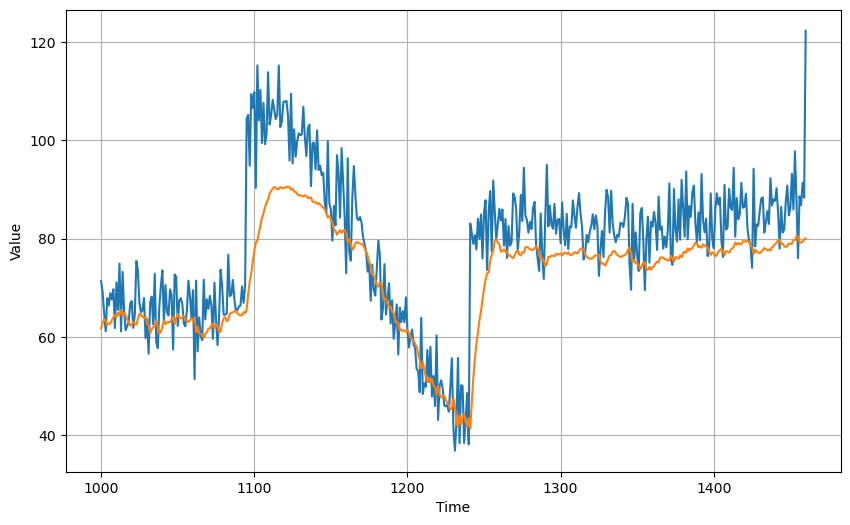

In [13]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then generate the metrics to evaluate the model's performance.

In [14]:
# Compute the MSE and MAE
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

101.36935
7.5072083


## Wrap Up

This concludes this short exercise on using LSTMs for time series forecasting. Next week, you will build upon this and add convolutions. Then, you will start to move away from synthetic data and use real-world datasets. See you there!

## Optional: Including a Validation Set while Training

Back in the first course of this specialization, you saw how you can also monitor the performance of your model against a validation set while training. You can also do that for this lab. 

First, you need to generate a `val_set` which are data windows and labels that your model can accept. You can simply reuse the `windowed_dataset` function for that and you can pass in the `x_valid` points to generate the windows.

In [15]:
# Generate data windows of the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

You can then do the same training as before but pass in the `val_set` to the `validation_data` parameter of the `fit()` method.

In [16]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100, validation_data=val_set)

Epoch 1/100
     26/Unknown 1s 5ms/step - loss: 101.1991 - mae: 101.6987

2025-01-08 16:06:32.906996: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:32.907093: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 94.1191 - mae: 94.6185 - val_loss: 15.6927 - val_mae: 16.1860
Epoch 2/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14.7752 - mae: 15.2692

2025-01-08 16:06:33.151231: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:33.151257: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:06:33.151261: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12334074372260843447


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 13.6273 - mae: 14.1195 - val_loss: 25.2500 - val_mae: 25.7495
Epoch 3/100
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.5406 - mae: 9.0277

2025-01-08 16:06:33.481421: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:33.481490: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.4522 - mae: 8.9390 - val_loss: 21.2582 - val_mae: 21.7541
Epoch 4/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1372 - mae: 7.6135

2025-01-08 16:06:33.760305: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:33.790141: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:33.790170: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.1686 - mae: 7.6481 - val_loss: 18.6354 - val_mae: 19.1303
Epoch 5/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3864 - mae: 6.8635

2025-01-08 16:06:34.037933: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:34.073359: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5714 - mae: 7.0505 - val_loss: 16.4078 - val_mae: 16.9051
Epoch 6/100
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.1297 - mae: 6.6013

2025-01-08 16:06:34.433244: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:34.433298: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.2089 - mae: 6.6823 - val_loss: 14.8392 - val_mae: 15.3331
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.9898 - mae: 6.4666 - val_loss: 13.7156 - val_mae: 14.2095
Epoch 8/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4705 - mae: 5.9459

2025-01-08 16:06:35.079123: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:35.079192: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:06:35.079215: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:35.167603: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:35.167669: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:06:35.167688: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12334074372260843447


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.8293 - mae: 6.3080 - val_loss: 12.8175 - val_mae: 13.3128
Epoch 9/100
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6918 - mae: 6.1711

2025-01-08 16:06:35.528559: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:35.528625: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:06:35.528644: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12334074372260843447


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7122 - mae: 6.1918 - val_loss: 12.1164 - val_mae: 12.6108
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6234 - mae: 6.1021 - val_loss: 11.5276 - val_mae: 12.0184
Epoch 11/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2782 - mae: 5.7536

2025-01-08 16:06:36.076831: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:36.076903: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5479 - mae: 6.0269 - val_loss: 11.0645 - val_mae: 11.5532
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4755 - mae: 5.9540 - val_loss: 10.6547 - val_mae: 11.1434
Epoch 13/100
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3925 - mae: 5.8713

2025-01-08 16:06:36.822912: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:36.822929: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:06:36.822933: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12334074372260843447


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4076 - mae: 5.8867 - val_loss: 10.3133 - val_mae: 10.8036
Epoch 14/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0558 - mae: 5.5309

2025-01-08 16:06:37.024315: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:37.024389: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:37.024524: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3455 - mae: 5.8244 - val_loss: 10.0277 - val_mae: 10.5186
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2871 - mae: 5.7655

2025-01-08 16:06:37.387618: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:06:37.573532: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:37.573608: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2900 - mae: 5.7686 - val_loss: 9.7692 - val_mae: 10.2579
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2371 - mae: 5.7167 - val_loss: 9.5644 - val_mae: 10.0524
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1926 - mae: 5.6728 - val_loss: 9.3692 - val_mae: 9.8573
Epoch 18/100
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0465 - mae: 5.5238

2025-01-08 16:06:38.330057: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1504 - mae: 5.6294 - val_loss: 9.2034 - val_mae: 9.6916
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1118 - mae: 5.5898 - val_loss: 9.0672 - val_mae: 9.5552
Epoch 20/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0011 - mae: 5.4773

2025-01-08 16:06:39.060590: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:39.060657: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:06:39.060677: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12334074372260843447


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0740 - mae: 5.5518 - val_loss: 8.9445 - val_mae: 9.4325
Epoch 21/100
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9423 - mae: 5.4189

2025-01-08 16:06:39.422692: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:39.422734: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:06:39.422747: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12334074372260843447


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0417 - mae: 5.5196 - val_loss: 8.8355 - val_mae: 9.3227
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0079 - mae: 5.4862

2025-01-08 16:06:39.797859: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0106 - mae: 5.4890 - val_loss: 8.7221 - val_mae: 9.2084
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9801 - mae: 5.4597 - val_loss: 8.6110 - val_mae: 9.0967
Epoch 24/100
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8708 - mae: 5.3505

2025-01-08 16:06:40.280771: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:40.280813: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9504 - mae: 5.4303 - val_loss: 8.5341 - val_mae: 9.0191
Epoch 25/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9150 - mae: 5.3954

2025-01-08 16:06:40.640739: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:40.640803: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:06:40.640817: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12334074372260843447


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9241 - mae: 5.4045 - val_loss: 8.4649 - val_mae: 8.9485
Epoch 26/100
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8840 - mae: 5.3646

2025-01-08 16:06:40.923734: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9008 - mae: 5.3813 - val_loss: 8.3595 - val_mae: 8.8417
Epoch 27/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6702 - mae: 5.1511

2025-01-08 16:06:41.127687: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:41.127729: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:06:41.127737: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 3553540260335934767
2025-01-08 16:06:41.127746: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:06:41.127753: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:41.127758: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 2424984523149011988
2025-01-08 16:06:41.189072: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8754 - mae: 5.3560 - val_loss: 8.2910 - val_mae: 8.7722
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8505 - mae: 5.3311 - val_loss: 8.2295 - val_mae: 8.7107
Epoch 29/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7322 - mae: 5.2124

2025-01-08 16:06:41.866297: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.8335 - mae: 5.3138 - val_loss: 8.1964 - val_mae: 8.6779
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8169 - mae: 5.2972 - val_loss: 8.1611 - val_mae: 8.6431
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8051 - mae: 5.2856 - val_loss: 8.1336 - val_mae: 8.6162
Epoch 32/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5984 - mae: 5.0773

2025-01-08 16:06:42.920121: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:42.920198: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:06:42.920223: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:06:42.920239: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7931 - mae: 5.2735 - val_loss: 8.0594 - val_mae: 8.5421
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7725 - mae: 5.2527 - val_loss: 8.0233 - val_mae: 8.5067
Epoch 34/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6383 - mae: 5.1171

2025-01-08 16:06:43.644365: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:43.644435: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:06:43.644457: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7586 - mae: 5.2384 - val_loss: 7.9714 - val_mae: 8.4557
Epoch 35/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4945 - mae: 4.9708

2025-01-08 16:06:43.922471: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:43.922553: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:43.922702: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7423 - mae: 5.2216 - val_loss: 7.9348 - val_mae: 8.4200
Epoch 36/100
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6846 - mae: 5.1628

2025-01-08 16:06:44.365822: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:44.365895: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:06:44.365925: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12334074372260843447


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7306 - mae: 5.2094 - val_loss: 7.8922 - val_mae: 8.3781
Epoch 37/100
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6980 - mae: 5.1768

2025-01-08 16:06:44.617874: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:44.617905: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:06:44.617912: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 3553540260335934767
2025-01-08 16:06:44.617920: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:06:44.617926: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:44.617930: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 2424984523149011988


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7166 - mae: 5.1957 - val_loss: 7.8452 - val_mae: 8.3316
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7034 - mae: 5.1828 - val_loss: 7.8339 - val_mae: 8.3216
Epoch 39/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5822 - mae: 5.0614

2025-01-08 16:06:45.219542: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:45.247645: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:45.247662: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:06:45.247665: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12334074372260843447


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6975 - mae: 5.1774 - val_loss: 7.8029 - val_mae: 8.2911
Epoch 40/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4520 - mae: 4.9305

2025-01-08 16:06:45.526990: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:45.527079: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:45.608041: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6872 - mae: 5.1675 - val_loss: 7.7677 - val_mae: 8.2560
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6769 - mae: 5.1573 - val_loss: 7.7487 - val_mae: 8.2375
Epoch 42/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4929 - mae: 4.9731

2025-01-08 16:06:46.283653: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:46.283725: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:06:46.283740: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 3553540260335934767
2025-01-08 16:06:46.283759: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:06:46.283799: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:46.283810: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 2424984523149011988
2025-01-08 16:06:46.366321: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6693 - mae: 5.1501 - val_loss: 7.7207 - val_mae: 8.2097
Epoch 43/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5719 - mae: 5.0528

2025-01-08 16:06:46.627616: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:46.627645: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:06:46.627650: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 3553540260335934767
2025-01-08 16:06:46.627658: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:06:46.627663: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:46.627667: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 2424984523149011988


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6602 - mae: 5.1411 - val_loss: 7.7358 - val_mae: 8.2255
Epoch 44/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5570 - mae: 5.0391

2025-01-08 16:06:46.919480: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:46.919555: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6573 - mae: 5.1389 - val_loss: 7.7173 - val_mae: 8.2071
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6498 - mae: 5.1316 - val_loss: 7.6809 - val_mae: 8.1705
Epoch 46/100
24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6063 - mae: 5.0884

2025-01-08 16:06:47.600762: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:47.600849: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:06:47.600873: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12334074372260843447


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6397 - mae: 5.1213 - val_loss: 7.6360 - val_mae: 8.1254
Epoch 47/100
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5854 - mae: 5.0672

2025-01-08 16:06:47.947584: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:47.947666: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6287 - mae: 5.1099 - val_loss: 7.6261 - val_mae: 8.1156
Epoch 48/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3413 - mae: 4.8242

2025-01-08 16:06:48.228539: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6238 - mae: 5.1049 - val_loss: 7.6306 - val_mae: 8.1202
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6243 - mae: 5.1053 - val_loss: 7.6141 - val_mae: 8.1035
Epoch 50/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5159 - mae: 4.9974

2025-01-08 16:06:48.977249: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:48.977267: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:06:48.977270: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 3553540260335934767
2025-01-08 16:06:48.977275: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:06:48.977278: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:48.977280: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 2424984523149011988
2025-01-08 16:06:49.000448: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6205 - mae: 5.1010 - val_loss: 7.5838 - val_mae: 8.0729
Epoch 51/100
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5560 - mae: 5.0362

2025-01-08 16:06:49.252597: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:49.252652: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6131 - mae: 5.0927 - val_loss: 7.5736 - val_mae: 8.0627
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6096 - mae: 5.0893 - val_loss: 7.5342 - val_mae: 8.0228
Epoch 53/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4559 - mae: 4.9373

2025-01-08 16:06:49.812258: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:49.888504: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:49.888525: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:06:49.888529: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12334074372260843447


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6040 - mae: 5.0836 - val_loss: 7.5252 - val_mae: 8.0138
Epoch 54/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3918 - mae: 4.8743

2025-01-08 16:06:50.154124: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:50.154203: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:50.223035: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5991 - mae: 5.0788 - val_loss: 7.5031 - val_mae: 7.9917
Epoch 55/100
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5403 - mae: 5.0211

2025-01-08 16:06:50.590712: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:50.590794: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:06:50.590811: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12334074372260843447


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5957 - mae: 5.0757 - val_loss: 7.5075 - val_mae: 7.9966
Epoch 56/100
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5420 - mae: 5.0233

2025-01-08 16:06:50.973359: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:50.973426: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5961 - mae: 5.0763 - val_loss: 7.4602 - val_mae: 7.9488
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5866 - mae: 5.0667 - val_loss: 7.4515 - val_mae: 7.9403
Epoch 58/100
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5287 - mae: 5.0098

2025-01-08 16:06:51.639184: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:51.639207: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:51.700356: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5832 - mae: 5.0633 - val_loss: 7.4276 - val_mae: 7.9162
Epoch 59/100
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5379 - mae: 5.0189

2025-01-08 16:06:52.022567: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:52.022614: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:06:52.022627: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12334074372260843447


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5772 - mae: 5.0573 - val_loss: 7.3988 - val_mae: 7.8873
Epoch 60/100
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5182 - mae: 4.9992

2025-01-08 16:06:52.383079: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:52.383130: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5729 - mae: 5.0529 - val_loss: 7.3955 - val_mae: 7.8842
Epoch 61/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3373 - mae: 4.8208

2025-01-08 16:06:52.679215: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:52.679272: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5700 - mae: 5.0500 - val_loss: 7.3703 - val_mae: 7.8590
Epoch 62/100
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5503 - mae: 5.0308

2025-01-08 16:06:53.130376: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:53.130407: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5653 - mae: 5.0451 - val_loss: 7.3493 - val_mae: 7.8379
Epoch 63/100
24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5291 - mae: 5.0097

2025-01-08 16:06:53.361505: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:53.361567: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5595 - mae: 5.0393 - val_loss: 7.3266 - val_mae: 7.8151
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5561 - mae: 5.0360 - val_loss: 7.3018 - val_mae: 7.7901
Epoch 65/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3964 - mae: 4.8787

2025-01-08 16:06:53.931937: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:53.931969: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5492 - mae: 5.0290 - val_loss: 7.2878 - val_mae: 7.7761
Epoch 66/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4050 - mae: 4.8871

2025-01-08 16:06:54.236439: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:54.307391: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5467 - mae: 5.0264 - val_loss: 7.2660 - val_mae: 7.7541
Epoch 67/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3431 - mae: 4.8259

2025-01-08 16:06:54.578455: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:54.578522: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:06:54.578545: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:54.662111: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:54.662186: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5422 - mae: 5.0217 - val_loss: 7.2502 - val_mae: 7.7381
Epoch 68/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4591 - mae: 4.9399

2025-01-08 16:06:54.910233: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5382 - mae: 5.0176 - val_loss: 7.2333 - val_mae: 7.7211
Epoch 69/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3832 - mae: 4.8651

2025-01-08 16:06:55.202904: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:55.202970: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:55.280791: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5350 - mae: 5.0140 - val_loss: 7.2222 - val_mae: 7.7099
Epoch 70/100
 7/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2512 - mae: 4.7343

2025-01-08 16:06:55.545215: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:55.545290: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:06:55.545314: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:06:55.545328: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5337 - mae: 5.0125 - val_loss: 7.2142 - val_mae: 7.7018
Epoch 71/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3336 - mae: 4.8159

2025-01-08 16:06:55.944887: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:06:55.944961: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:55.945020: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:06:55.945099: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5309 - mae: 5.0096 - val_loss: 7.2038 - val_mae: 7.6913
Epoch 72/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3329 - mae: 4.8151

2025-01-08 16:06:56.335282: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:56.335351: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:06:56.335374: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:56.413234: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5292 - mae: 5.0079 - val_loss: 7.1734 - val_mae: 7.6605
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5240 - mae: 5.0026 - val_loss: 7.1639 - val_mae: 7.6508
Epoch 74/100
24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4910 - mae: 4.9702

2025-01-08 16:06:57.181086: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5212 - mae: 4.9996 - val_loss: 7.1515 - val_mae: 7.6381
Epoch 75/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3503 - mae: 4.8313

2025-01-08 16:06:57.412451: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:57.412498: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:06:57.412514: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:06:57.412524: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5195 - mae: 4.9977 - val_loss: 7.1224 - val_mae: 7.6085
Epoch 76/100
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4597 - mae: 4.9388

2025-01-08 16:06:57.774553: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:57.774602: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:06:57.774610: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 3553540260335934767
2025-01-08 16:06:57.774620: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:06:57.774627: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:57.774632: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 2424984523149011988
2025-01-08 16:06:57.811058: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5142 - mae: 4.9924 - val_loss: 7.1034 - val_mae: 7.5891
Epoch 77/100
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4460 - mae: 4.9252

2025-01-08 16:06:58.107558: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:58.107640: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:06:58.107668: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12334074372260843447


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5119 - mae: 4.9901 - val_loss: 7.0940 - val_mae: 7.5795
Epoch 78/100
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4709 - mae: 4.9499

2025-01-08 16:06:58.439274: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:06:58.439325: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5099 - mae: 4.9880 - val_loss: 7.0901 - val_mae: 7.5755
Epoch 79/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3117 - mae: 4.7926

2025-01-08 16:06:58.685181: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:58.685253: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5082 - mae: 4.9862 - val_loss: 7.0811 - val_mae: 7.5663
Epoch 80/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3866 - mae: 4.8660

2025-01-08 16:06:59.047970: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:59.047998: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:06:59.048006: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:06:59.048012: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5073 - mae: 4.9853 - val_loss: 7.0539 - val_mae: 7.5385
Epoch 81/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4245 - mae: 4.9032

2025-01-08 16:06:59.331808: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:59.331839: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:06:59.331845: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 3553540260335934767
2025-01-08 16:06:59.331852: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:06:59.331859: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:06:59.331863: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 2424984523149011988
2025-01-08 16:06:59.401970: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5029 - mae: 4.9807 - val_loss: 7.0528 - val_mae: 7.5373
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5025 - mae: 4.9802 - val_loss: 7.0430 - val_mae: 7.5274
Epoch 83/100
 7/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2183 - mae: 4.6993 

2025-01-08 16:06:59.942941: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:06:59.943038: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5003 - mae: 4.9779 - val_loss: 7.0093 - val_mae: 7.4932
Epoch 84/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3255 - mae: 4.8046

2025-01-08 16:07:00.388293: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:07:00.388359: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:07:00.388383: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:07:00.388398: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.4957 - mae: 4.9730 - val_loss: 6.9968 - val_mae: 7.4805
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4940 - mae: 4.9712 - val_loss: 6.9857 - val_mae: 7.4692
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4924 - mae: 4.9695 - val_loss: 6.9791 - val_mae: 7.4625
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4914 - mae: 4.9681 - val_loss: 6.9640 - val_mae: 7.4473
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4893 - mae: 4.9661 - val_loss: 6.9436 - val_mae: 7.4268
Epoch 89/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3157 - mae: 4.7941

2025-01-08 16:07:02.067463: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:07:02.067539: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4858 - mae: 4.9627 - val_loss: 6.9321 - val_mae: 7.4151
Epoch 90/100
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4769 - mae: 4.9541

2025-01-08 16:07:02.456200: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:07:02.456243: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:07:02.456255: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12334074372260843447


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4843 - mae: 4.9611 - val_loss: 6.9277 - val_mae: 7.4107
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4853 - mae: 4.9621 - val_loss: 6.9253 - val_mae: 7.4083
Epoch 92/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3349 - mae: 4.8130

2025-01-08 16:07:03.001435: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:07:03.001503: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:07:03.001527: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:07:03.001542: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4834 - mae: 4.9602 - val_loss: 6.9148 - val_mae: 7.3977
Epoch 93/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3337 - mae: 4.8116

2025-01-08 16:07:03.358803: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:07:03.358878: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4822 - mae: 4.9590 - val_loss: 6.9160 - val_mae: 7.3989
Epoch 94/100
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4189 - mae: 4.8961

2025-01-08 16:07:03.811754: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4830 - mae: 4.9597 - val_loss: 6.9027 - val_mae: 7.3854
Epoch 95/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3927 - mae: 4.8698

2025-01-08 16:07:04.182585: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.4810 - mae: 4.9576 - val_loss: 6.8940 - val_mae: 7.3766
Epoch 96/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3327 - mae: 4.8109

2025-01-08 16:07:04.510348: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:07:04.510422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:07:04.510453: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:07:04.594385: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:07:04.594461: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:07:04.594487: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12334074372260843447


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4800 - mae: 4.9570 - val_loss: 6.8904 - val_mae: 7.3729
Epoch 97/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3501 - mae: 4.8280

2025-01-08 16:07:04.867566: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:07:04.867633: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:07:04.867654: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4797 - mae: 4.9567 - val_loss: 6.8690 - val_mae: 7.3513
Epoch 98/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3890 - mae: 4.8670

2025-01-08 16:07:05.183617: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6132628816798708267
2025-01-08 16:07:05.183651: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5305552155051642365
2025-01-08 16:07:05.183658: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 3553540260335934767
2025-01-08 16:07:05.183666: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072806792996114535
2025-01-08 16:07:05.183675: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8891391430016268987
2025-01-08 16:07:05.183679: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 2424984523149011988


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4771 - mae: 4.9543 - val_loss: 6.8588 - val_mae: 7.3409
Epoch 99/100
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4654 - mae: 4.9432

2025-01-08 16:07:05.582902: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:07:05.582967: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
2025-01-08 16:07:05.582988: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12334074372260843447


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4749 - mae: 4.9523 - val_loss: 6.8467 - val_mae: 7.3286
Epoch 100/100
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4362 - mae: 4.9144

2025-01-08 16:07:05.835088: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15617092281234063878
2025-01-08 16:07:05.835161: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4734 - mae: 4.9509 - val_loss: 6.8494 - val_mae: 7.3313


2025-01-08 16:07:06.153494: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12342095380777983080
